# Raster awareness API

This notebook will give an overview of newly developed raster interface. We'll cover 
basic usage of the functionality offered by the interface which mainly involves:
1. converting `xarray.DataArray` object to the PySAL's weights object (`libpysal.weights.W`/`WSP`).
2. going back to the `xarray.DataArray` from weights object.

using different datasets:
- with missing values.
- with multiple layers.
- with non conventional dimension names.

In [1]:
%matplotlib inline

from libpysal.weights import Rook, Queen, KNN
from libpysal.weights import raster
import libpysal as lp
import numpy as np
import xarray as xr
import pandas as pd
from esda import Moran_Local

/data/GSoC/libpysal/libpysal/examples/remotes.py:26: UserWarning: Remote data sets not available. Check connection.
  warnings.warn("Remote data sets not available. Check connection.")


## Loading Data

*The interface only accepts `xarray.DataArray`*, this can be easily obtained from raster data
format using `xarray`'s I/O functionality which can read from a variety of data formats some of them are listed below: 
- [GDAL Raster Formats](https://svn.osgeo.org/gdal/tags/gdal_1_2_5/frmts/formats_list.html) via `open_rasterio` method.
- [NetCDF](https://www.unidata.ucar.edu/software/netcdf/) via `open_dataset` method.

In this notebook we'll work with `NetCDF` and `GeoTIFF` data. 

### Using xarray example dataset
First lets load up a `netCDF` dataset offered by xarray.

In [2]:
ds = xr.tutorial.open_dataset("air_temperature.nc")  # -> returns a xarray.Dataset object
da = ds["air"]  # we'll use the "air" data variable for further analysis
print(da)

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
[3869000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]


`xarray`'s data structures like `Dataset` and `DataArray` provides `pandas` like functionality for multidimensional-array or ndarray. 

In our case we'll mainly deal with `DataArray`, we can see above that the `da` holds the data for air temperature, it has 2 dims coordinate dimensions `x` and `y`, and it's layered on `time` dimension so in total 3 dims (`time`, `lat`, `lon`).

We'll now group `da` by month and take average over the `time` dimension



In [3]:
da = da.groupby('time.month').mean()
print(da.coords)  # as a result time dim is replaced by month 

Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12


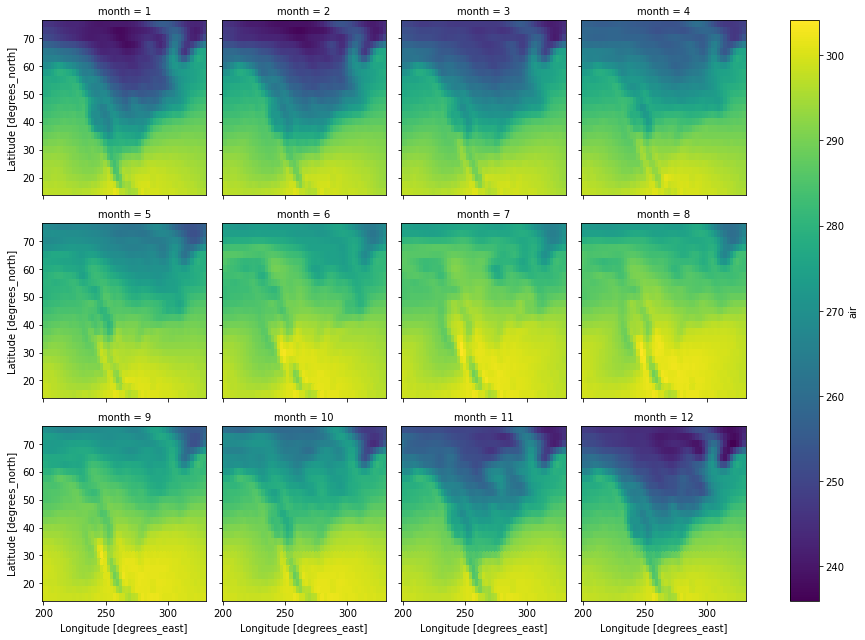

In [4]:
# let's plot over month, each facet will represent the mean air temperature in a given month.
da.plot(col="month", col_wrap=4,) 

We can use `from_xarray` method from the contiguity classes like `Rook` and `Queen`, and also from `KNN`.

This uses a util function in `raster.py` file called `da2W`, which can also be called directly to build `W` object, similarly `da2WSP` for building `WSP` object.

**Weight builders (`from_xarray`, `da2W`, `da2WSP`) can recognise dimensions belonging to this list `[band, time, lat, y, lon, x]`, if any of the dimension in the `DataArray` does not belong to the mentioned list then we need to pass a dictionary (specifying that dimension's name) to the weight builder.** 

e.g. `dims` dictionary:
```python
>>> da.dims                  # none of the dimension belong to the default dimension list
('year', 'height', 'width')
>>> dims = {                 # dimension values should be properly aligned with the following keys
        "layer": "year",
        "lat": "height",
        "lon": "width"
    }
```


In [5]:
dims = {}
dims["layer"] = "month"  # since month does not belong to the default list we need to pass it using a dictionary
w_queen = Queen.from_xarray(
    da, layer=12, dims=dims, sparse=False)  # We'll use data from 12th layer (in our case layer=month)

`index` is a newly added attribute to the weights object, this holds the multi-indices of the non-missing values belonging to `pandas.Series` created from the passed `DataArray`, this series can be easily obtained using `DataArray.to_series()` method.

In [6]:
w_queen.index[:5]  # indices are aligned to the ids of the weight object

MultiIndex([(12, 75.0, 200.0),
            (12, 75.0, 202.5),
            (12, 75.0, 205.0),
            (12, 75.0, 207.5),
            (12, 75.0, 210.0)],
           names=['month', 'lat', 'lon'])

We can then obtain raster data by converting the `DataArray` to `Series` and then using indices from `index` attribute to get non-missing values by subsetting the `Series`. 

In [7]:
data = da.to_series()[w_queen.index]
data = np.array(data, dtype=np.float64)

We now have the required data for further analysis (we can now use methods such as ESDA/spatial regression), for this example let's compute a local Moran statistic for the extracted data.

In [8]:
# Quickly computing and loading a LISA
np.random.seed(12345)
lisa = Moran_Local(np.array(data, dtype=np.float64), w_queen)

After getting our calculated results it's time to store them back to the `DataArray`, we can use `w2da` function directly to convert the `W` object back to `DataArray`. 

*Your use case might differ but the steps for using the interface will be similar to this example.* 

In [9]:
# Converting obtained data back to DataArray
moran_da = raster.w2da(lisa.p_sim, w_queen)  # w2da accepts list/1d array/pd.Series and a weight object aligned to passed data
print(moran_da)

<xarray.DataArray (month: 1, lat: 25, lon: 53)>
array([[[0.018, 0.001, 0.001, ..., 0.001, 0.001, 0.001],
        [0.001, 0.001, 0.001, ..., 0.001, 0.001, 0.001],
        [0.003, 0.001, 0.001, ..., 0.001, 0.001, 0.001],
        ...,
        [0.002, 0.001, 0.001, ..., 0.001, 0.001, 0.003],
        [0.001, 0.001, 0.001, ..., 0.001, 0.001, 0.003],
        [0.002, 0.001, 0.001, ..., 0.001, 0.002, 0.006]]])
Coordinates:
  * month    (month) int64 12
  * lat      (lat) float64 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float64 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0


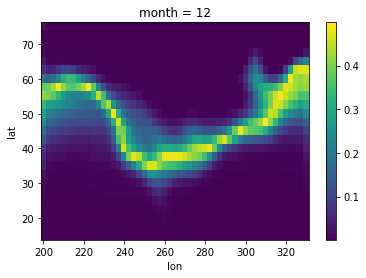

In [10]:
moran_da.plot()

### Using local `NetCDF` dataset

In the earlier example we used an example dataset from xarray for building weights object. Additonally, we had to pass the custom layer name to the builder. 

In this small example we'll build `KNN` distance weight object using a local `NetCDF` dataset with different dimensions names which doesn't belong to the default list of dimensions.

We'll also see how to speed up the reverse journey (from weights object to `DataArray`) by passing prebuilt `coords` and `attrs` to `w2da` method. 

In [11]:
# Lets load a netCDF Surface dataset
ds = xr.open_dataset('ECMWF_ERA-40_subset.nc')    # After loading netCDF dataset we obtained a xarray.Dataset object
print(ds)                                         # This Dataset object containes several data variables

<xarray.Dataset>
Dimensions:    (latitude: 73, longitude: 144, time: 62)
Coordinates:
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * time       (time) datetime64[ns] 2002-07-01T12:00:00 ... 2002-07-31T18:00:00
Data variables:
    tcw        (time, latitude, longitude) float32 ...
    tcwv       (time, latitude, longitude) float32 ...
    lsp        (time, latitude, longitude) float32 ...
    cp         (time, latitude, longitude) float32 ...
    msl        (time, latitude, longitude) float32 ...
    blh        (time, latitude, longitude) float32 ...
    tcc        (time, latitude, longitude) float32 ...
    p10u       (time, latitude, longitude) float32 ...
    p10v       (time, latitude, longitude) float32 ...
    p2t        (time, latitude, longitude) float32 ...
    p2d        (time, latitude, longitude) float32 ...
    e          (time, latitude, longitude) float32 ...
  

Out of 17 data variables we'll use `p2t` for our analysis. This will give us our desired `DataArray` object `da`, we will further group `da` by day, taking average over the `time` dimension.

In [12]:
da = ds["p2t"]  # this will give us the required DataArray with p2t (2 metre temperature) data variable
da = da.groupby('time.day').mean()
print(da.dims)

('day', 'latitude', 'longitude')


**We can see that the none of dimensions of `da` matches with the default dimensions (`[band, time, lat, y, lon, x]`)**

This means we have to create a dictionary mentioning the dimensions and ship it to weight builder, similar to our last example. 

In [13]:
dims = {}
dims["lat"] = "latitude"
dims["lon"] = "longitude"
dims["layer"] = "day"
w_knn = KNN.from_xarray(da, layer=13, dims=dims, k=8)

In [14]:
data = da.to_series()[w_knn.index]  # we derived the data from DataArray similar to our last example 

In the last example we only passed the `data` values and weight object to `w2da` method, which then created the necessary `coords` to build our required `DataArray`. This process can be speed up by passing `coords` from the existing `DataArray` `da` which we used earlier.

Along with `coords` we can also pass `attrs` of the same `DataArray` this will help `w2da` to retain all the properties of original `DataArray`.

Let's compare the `DataArray` returned by `w2da` and original `DataArray`. For this we'll ship the derived data straight to `w2da` without any statistical analysis.

In [15]:
da1 = raster.w2da(data, w_knn, attrs=da.attrs, coords=da[12:13].coords)
xr.DataArray.equals(da[12:13], da1)  # method to compare 2 DataArray, if true then w2da was successfull

True

### Using local `GeoTIFF` dataset

Up until now we've only played with `netCDF` datasets but in this example we'll use a `raster.tif` file to see how interface interacts with it. We'll also see how these methods handle missing data. 

Unlike earlier we'll use weight builder methods from `raster.py`, which we can call directly. Just a reminder that `from_xarray` uses methods from `raster.py` and therefore only difference exists in the API. 

To access GDAL Raster Formats `xarray` offers `open_rasterio` method which uses `rasterio` as backend. It loads metadata, coordinate values from the raster file and assign them to the `DataArray`.  

In [16]:
# Loading raster data with missing values
da = xr.open_rasterio('lux_ppp_2019.tif')
print(da)

<xarray.DataArray (band: 1, y: 880, x: 940)>
[827200 values with dtype=float32]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 50.18 50.18 50.18 50.18 ... 49.45 49.45 49.45 49.45
  * x        (x) float64 5.745 5.746 5.747 5.747 ... 6.525 6.526 6.527 6.527
Attributes:
    transform:      (0.0008333333297872345, 0.0, 5.744583325, 0.0, -0.0008333...
    crs:            +init=epsg:4326
    res:            (0.0008333333297872345, 0.0008333333295454553)
    is_tiled:       0
    nodatavals:     (-99999.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area


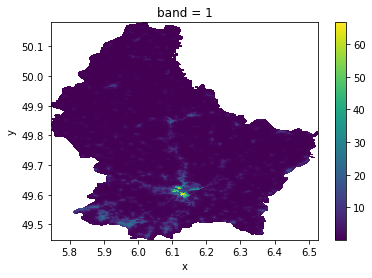

In [17]:
da.where(da.values>da.attrs["nodatavals"][0]).plot() # we can see that the DataArray contains missing values.

We'll look at how weight builders handle missing values. Firstly we'll slice the `DataArray` to reduce overall size for easier visualization.

This time we'll create `WSP` object using `da2WSP` method inside `raster.py`. Since our DataArray is single banded and all of its dimensions belong to the default list, we only have to ship the DataArray and the type of contiguity we need.

In [18]:
# Slicing the dataarray
da_s = da[:, 330:340, 129:139]
w_queen = raster.da2WSP(da_s)  # default contiguity is queen
w_rook = raster.da2WSP(da_s, "rook")

After plotting both contiguities and sliced `DataArray`, we can see that the missing values are ignored by the `da2WSP` method and only indices of non missing values are stored in `index` attribute of `WSP` object. 

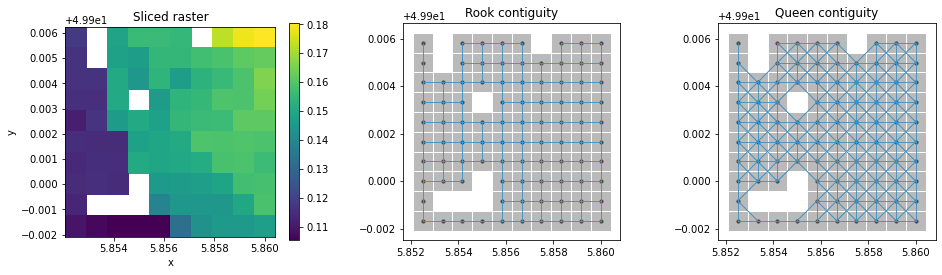

In [20]:
f,ax = plt.subplots(1,3,figsize=(4*4,4), subplot_kw=dict(aspect='equal'))
da_s.where(da_s.values>da_s.attrs["nodatavals"][0]).plot(ax=ax[0])
ax[0].set_title("Sliced raster")
plot_spatial_weights(w_rook, da_s, ax=ax[1])
ax[1].set_title("Rook contiguity")
plot_spatial_weights(w_queen, da_s, ax=ax[2])
ax[2].set_title("Queen contiguity")
plt.show()

## Additional resources

1. [Reading and writing files using Xarray](http://xarray.pydata.org/en/stable/io.html)
2. [Xarray Data Structures](http://xarray.pydata.org/en/stable/data-structures.html)

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from shapely.geometry import Polygon
import geopandas as gpd

def plot_spatial_weights(w, da, ax=None, figsize=(10,10)):
    def _buildPoly(df, x, y, res):
        geometry = Polygon([(df[x]-res[0], df[y]-res[1]), 
                            (df[x]+res[0], df[y]-res[1]), 
                            (df[x]+res[0], df[y]+res[1]), 
                            (df[x]-res[0], df[y]+res[1])])
        return geometry
    
    index = w_queen.index
    df = index.to_frame(False)
    y,x = da.dims[-2:]
    res = np.zeros(2)
    if "transform" in da.attrs:
        res = (da.attrs["transform"][0]/2, da.attrs["transform"][4]/2)
    df["geometry"] = df.apply(_buildPoly, x=x, y=y, res=res, axis=1)
    gdf = gpd.GeoDataFrame(df)
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
    node_kws = dict(markersize=10, facecolor='#4d4d4d', edgecolor='#4d4d4d')
    edge_kws = dict(colors='#4393c3')
    edge_kws.setdefault('lw', 0.7)
    centroids_shp = gdf.centroid.values
    segments = []
    non_planar_segments = []
    index = w.index
    sparse = w.sparse
    for idx in range(len(index)):
        # Find the centroid of the polygon we're looking at now
        origin = np.array(centroids_shp[idx].coords)[0]
        for j in sparse[idx].indices:
            jdx = j
            dest = np.array(centroids_shp[jdx].coords)[0]
            segments.append([origin, dest])
    # Plot the polygons from the geodataframe as a base layer
    gdf.plot(ax=ax, color='#bababa', edgecolor='w')
    # plot polygon centroids
    gdf.centroid.plot(ax=ax, **node_kws)
    # plot weight edges
    segs_plot = LineCollection(np.array(segments), **edge_kws)
    ax.add_collection(segs_plot)
    ax.set_aspect('equal')
    return fig, ax